In [1]:
import numpy as np
from datetime import datetime
from scipy.interpolate import griddata
from scipy.spatial import Delaunay

import halem
import halem.mesh_maker as Mesh_maker
import halem.functions as Functions
import halem.path_finder as path_finder
import halem.base_functions as base_functions

import matplotlib.pyplot as plt

plt.style.use("ggplot")
%matplotlib inline

In [2]:
class flow_potentiaalveld:
    def __init__(self, name):
        d = datetime.strptime("23/03/2019 00:00:00", "%d/%m/%Y %H:%M:%S")
        t0 = d.timestamp()
        x = np.arange(0, 1, 0.04)
        y = np.arange(0, 1, 0.04)
        t = np.arange(t0, (t0 + 2 * 30 * 60 * 30), 30 * 60)

        y, x = np.meshgrid(y, x)
        y = y.reshape(y.size)
        x = x.reshape(y.size)

        nodes = np.zeros((len(x), 2))
        nodes[:, 0] = y
        nodes[:, 1] = x

        u = []
        v = []
        for node in nodes:
            ut = 0 * t + 2 * np.cos(np.pi * (node[0]))
            vt = 0 * t - 2 * np.cos(np.pi * (node[1]))
            u.append(ut)
            v.append(vt)

        self.v = np.transpose(np.array(v))
        self.u = np.transpose(np.array(u))
        #         self.WD = np.random.rand(self.u.shape[0],self.u.shape[1])*12 + 8
        self.WD = self.u * 0 + 20
        self.t = t
        self.nodes = nodes
        self.tria = Delaunay(nodes)


def compute_cost(week_rate, fuel_rate):
    second_rate = week_rate / 7 / 24 / 60 / 60
    return lambda travel_time, speed: (
        travel_time * second_rate + fuel_rate * travel_time * speed**3
    )


def compute_co2(fuel_rate):
    return lambda travel_time, speed: (fuel_rate * travel_time * speed**3)

In [3]:
nl = (3, 2.5)
dx_min = 0.1
blend = 1
vship = np.array([[1, 4, 8], [1, 5, 10]])
WD_min = np.array([8, 7])
WPVI = np.array([4000, 10000])
ukc = 1.5
WWL = 40
name_textfile_flow = "maaktnietuit"
Load_flow = flow_potentiaalveld
number_of_neighbor_layers = 2

Q_cost = compute_cost(700_000, 0.008)
Q_co2 = compute_co2(1)

In [4]:
%%time

Roadmap_t = Mesh_maker.GraphFlowModel(
    name_textfile_flow,
    dx_min,
    blend,
    nl,
    number_of_neighbor_layers,
    vship,
    Load_flow,
    WD_min,
    WPVI,
    WWL=WWL,
    ukc=ukc,
    compute_cost=Q_cost,
    compute_co2=Q_co2,
)



4/4
CPU times: user 3min 39s, sys: 10.7 s, total: 3min 50s
Wall time: 3min 39s


In [5]:
%%time

t0 = "23/03/2019 03:00:00"  # Departure time

start = (0.2, 0.2)
stop = (0.8, 0.8)
v_max = 7


path_t, time_t, dist_t = halem.base_functions.HALEM_time(
    start, stop, t0, v_max, Roadmap_t
)
path_s, time_s, dist_s = halem.base_functions.HALEM_space(
    start, stop, t0, v_max, Roadmap_t
)
path_c, time_c, dist_c = halem.base_functions.HALEM_cost(
    start, stop, t0, v_max, Roadmap_t
)
path_p, time_p, dist_p = halem.base_functions.HALEM_co2(
    start, stop, t0, v_max, Roadmap_t
)

CPU times: user 12.8 s, sys: 93.5 ms, total: 12.9 s
Wall time: 12.8 s


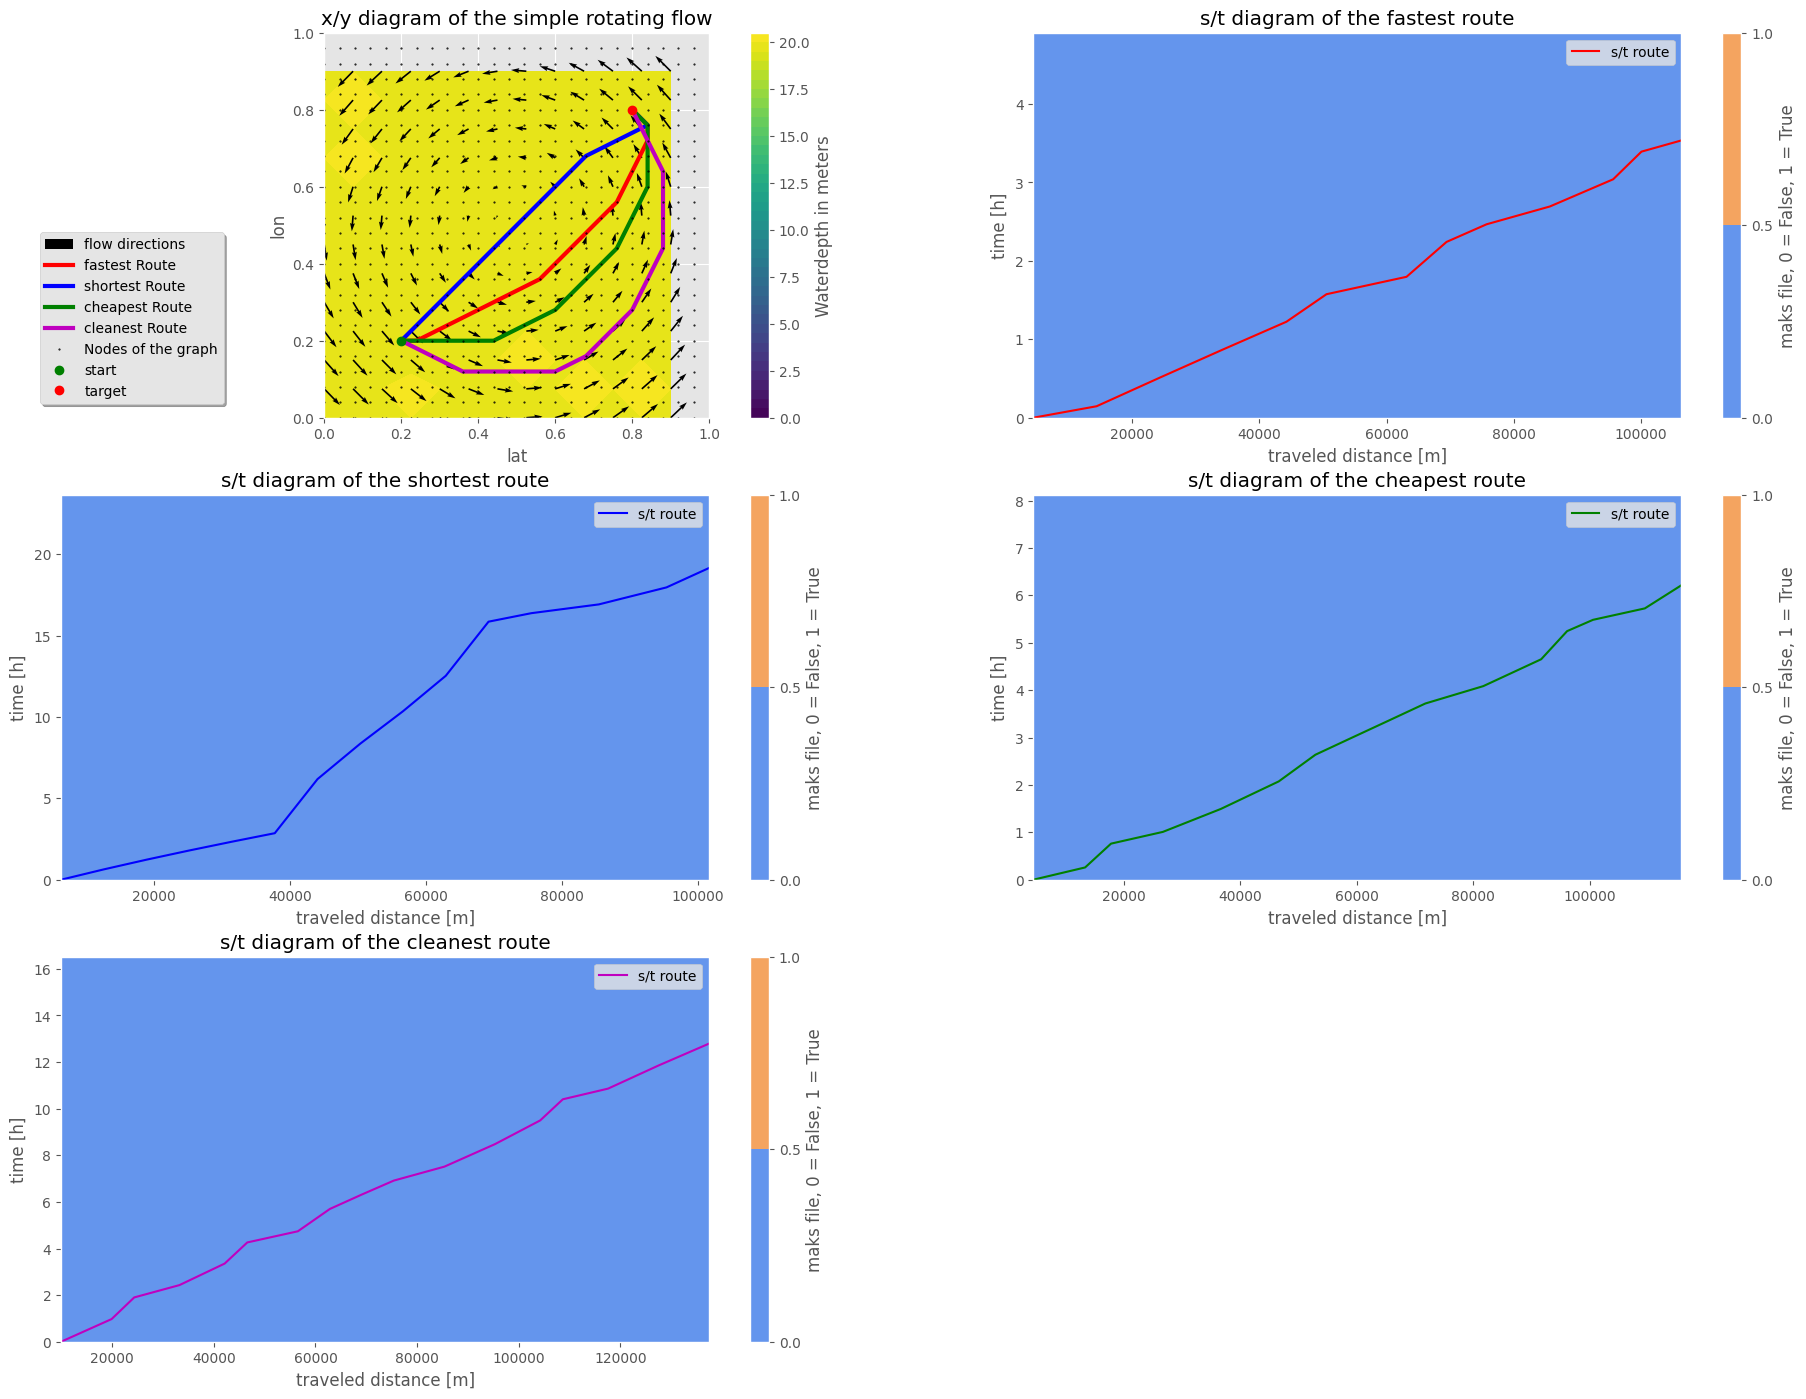

In [6]:
fig = plt.figure(figsize=(23, 17))

ax = plt.subplot(3, 2, 1)
plt.axis("square")
a = 1

x_r = np.arange(0, 1, 0.075)
y_r = np.arange(0, 1, 0.075)
y_r, x_r = np.meshgrid(y_r, x_r)

WD_r = griddata(
    (Roadmap_t.nodes[:, 1], Roadmap_t.nodes[:, 0]),
    Roadmap_t.WD[:, 0],
    (x_r, y_r),
    method="linear",
)
u_r = griddata(
    (Roadmap_t.nodes[:, 1], Roadmap_t.nodes[:, 0]),
    Roadmap_t.u[:, 0],
    (x_r, y_r),
    method="linear",
)
v_r = griddata(
    (Roadmap_t.nodes[:, 1], Roadmap_t.nodes[:, 0]),
    Roadmap_t.v[:, 0],
    (x_r, y_r),
    method="linear",
)

cval = np.arange(0, 21, 0.5)
im = plt.contourf(x_r, y_r, WD_r, cval)
fig.colorbar(im, ax=ax, label="Waterdepth in meters")

plt.quiver(
    x_r[::a, ::a], y_r[::a, ::a], u_r[::a, ::a], v_r[::a, ::a], label="flow directions"
)
plt.plot(path_t[:, 0], path_t[:, 1], "r", label="fastest Route", linewidth=3)
plt.plot(path_s[:, 0], path_s[:, 1], "b", label="shortest Route", linewidth=3)
plt.plot(path_c[:, 0], path_c[:, 1], "g", label="cheapest Route", linewidth=3)
plt.plot(path_p[:, 0], path_p[:, 1], "m", label="cleanest Route", linewidth=3)

plt.plot(
    Roadmap_t.nodes[:, 1],
    Roadmap_t.nodes[:, 0],
    "k.",
    label="Nodes of the graph",
    markersize=1,
)
plt.plot(path_t[0, 0], path_t[0, 1], "go", label="start")
plt.plot(path_t[-1, 0], path_t[-1, 1], "ro", label="target")


plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title(r"x/y diagram of the simple rotating flow")
ax.legend(
    loc="upper center", bbox_to_anchor=(-0.5, 0.5), ncol=1, fancybox=True, shadow=True
)
plt.xlabel("lat")
plt.ylabel("lon")

plt.subplot(3, 2, 2)
halem.base_functions.plot_timeseries2(path_t, time_t, Roadmap_t, "r")
plt.title("s/t diagram of the fastest route")


plt.subplot(3, 2, 3)
halem.base_functions.plot_timeseries2(path_s, time_s, Roadmap_t, "b")
plt.title("s/t diagram of the shortest route")


plt.subplot(3, 2, 4)
halem.base_functions.plot_timeseries2(path_c, time_c, Roadmap_t, "g")
plt.title("s/t diagram of the cheapest route")

plt.subplot(3, 2, 5)
halem.base_functions.plot_timeseries2(path_p, time_p, Roadmap_t, "m")
plt.title("s/t diagram of the cleanest route")

plt.show()